In [9]:
# Import packages
import sys
import os

import gymnasium as gym
import numpy as np
import matplotlib.pyplot as plt

import tqdm

import torch
import torch.optim as optim
from torch.autograd import Variable
import torch.nn.functional as F
import torch.nn as nn

from IPython.display import clear_output
from IPython import display

%matplotlib inline

# check and use GPU if available if not use CPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

from torch.distributions import MultivariateNormal, Normal


In [10]:
class ContinuousActor(nn.Module):
    def __init__(
        self, 
        in_dim: int, 
        out_dim: int, 
    ):
        """Initialize."""
        super(ContinuousActor, self).__init__()

        self.hidden1 = nn.Linear(in_dim, 32)
        self.hidden2 = nn.Linear(32, 32)
        self.hidden3 = nn.Linear(32, 32)
        self.mu_layer = nn.Linear(32, out_dim)
        self.log_std_layer = nn.Linear(32, out_dim)

    def forward(self, state: torch.Tensor) -> torch.Tensor:
        """Forward method implementation."""
        x = F.relu(self.hidden1(state))
        x = F.relu(self.hidden2(x))
        x = F.relu(self.hidden3(x))
        
        mu = torch.tanh(self.mu_layer(x))
        log_std = torch.tanh(self.log_std_layer(x))

        std = torch.exp(log_std)
        dist = Normal(mu, std)
        action = dist.sample()

        return action, dist

In [11]:
test_actor = ContinuousActor(3, 1)
action, dist = test_actor.forward(torch.tensor([1, 2, 3], dtype=torch.float32))

In [12]:
def new_reward_mountaincar(state, reward):
    if reward > 0:
        return 500
    pos = state[0]+0.5
    vel = state[1]
    return (abs(pos) + abs(vel)*14.2)

In [13]:
# CODE from another notebook
class NeuralNet(torch.nn.Module):
    def __init__(self, input_size, output_size, activation, layers=[32,32,16]):
        super().__init__()

        # Define layers with ReLU activation
        self.linear1 = torch.nn.Linear(input_size, layers[0])
        self.activation1 = torch.nn.ReLU()
        self.linear2 = torch.nn.Linear(layers[0], layers[1])
        self.activation2 = torch.nn.ReLU()
        self.linear3 = torch.nn.Linear(layers[1], layers[2])
        self.activation3 = torch.nn.ReLU()

        self.output_layer = torch.nn.Linear(layers[2], output_size)
        self.output_activation = activation

        # Initialization using Xavier normal (a popular technique for initializing weights in NNs)
        torch.nn.init.xavier_normal_(self.linear1.weight)
        torch.nn.init.xavier_normal_(self.linear2.weight)
        torch.nn.init.xavier_normal_(self.linear3.weight)
        torch.nn.init.xavier_normal_(self.output_layer.weight)

    def forward(self, inputs):
        # Forward pass through the layers
        x = self.activation1(self.linear1(inputs))
        x = self.activation2(self.linear2(x))
        x = self.activation3(self.linear3(x))
        x = self.output_activation(self.output_layer(x))
        return x

def normalize_reward(env, reward):
    """
    Normalize the reward between -1 and 1
    """
    return (reward + 8.1) / 8.1

def generate_single_episode(env, policy_net, eval=False):
    """
    Generates an episode by executing the current policy in the given env
    """
    states = []
    actions = []
    rewards = []
    log_probs = []
    max_t = 1000 # max horizon within one episode
    state, _ = env.reset()

    if isinstance(env.action_space, gym.spaces.Box):
        max_possible_action = float(env.action_space.high[0]) # Only works with a action space dim of 1
        min_possible_action = float(env.action_space.low[0]) # Only works with a action space dim of 1

    for t in range(max_t):
        #print(t)
        if isinstance(env.action_space, gym.spaces.Discrete):
            state = torch.from_numpy(state).float().unsqueeze(0)
        else:
            state = torch.from_numpy(state.flatten()).float()
            

        # if action space is discrete or continuous
        if isinstance(env.action_space, gym.spaces.Discrete):
            probs = policy_net.forward(Variable(state)) # get each action choice probability with the current policy network
            action = np.random.choice(env.action_space.n, p=np.squeeze(probs.detach().numpy())) # probablistic
        else:
            action, dist = policy_net.forward(state) # continuous
            # clip action to the action space
            action = torch.clamp(action, min=min_possible_action, max=max_possible_action)
            action = action.detach().numpy()
            probs = dist


        # compute the log_prob to use this in parameter update
        log_prob = None
        if isinstance(env.action_space, gym.spaces.Discrete):
            log_prob = torch.log(probs.squeeze(0)[action])
        else:
            log_prob = dist.log_prob(torch.tensor(action))
            # print(f"log_prob: {log_prob}")
            
        #print(log_prob)
        
        # append values
        states.append(state)
        actions.append(action)
        log_probs.append(log_prob)
        
        # take a selected action

        state, reward, terminated, truncated, _ = env.step(action)
        if terminated and env.spec.id == 'MountainCar-v0':
            print(f"Envrionement solved in {t} steps")
        if not eval:
            # normalize the reward between -1 and 1
            # reward = (reward + 8.1) / 8.1
            if isinstance(env.action_space, gym.spaces.Discrete):
                # env name == 'MountainCar-v0'
                if env.spec.id == 'MountainCar-v0':
                    # reward = new_reward_mountaincar(state, reward)
                    pass # do nothing
            else:
                reward = normalize_reward(env, reward)
        
        rewards.append(reward)

        if terminated | truncated:
            break
            
    return states, actions, rewards, log_probs


def evaluate_policy(env, policy_net):
    """
    Compute accumulative trajectory reward
    """
    states, actions, rewards, log_probs = generate_single_episode(env, policy_net, eval=True)
    return np.sum(rewards)

In [17]:
def train_PPO(env, policy_net, policy_optimizer, value_net, value_optimizer, num_epochs, clip_val=0.2, gamma=0.99, entropy_coef=0.005, lamda=0.95, vf_coef=1):
    """
    Trains the policy network using PPO
    """

    # Generate an episode with the current policy network
    states, actions, rewards, log_probs = generate_single_episode(env, policy_net)
    T = len(states)
    
    # Create tensors depending on if it is discrete or continuous action space
    if isinstance(env.action_space, gym.spaces.Discrete):
        actions = torch.LongTensor(actions).to(device).view(-1,1)
    else:
        actions = torch.FloatTensor(actions).to(device).view(-1,1)


    states = np.vstack(states).astype(float)
    states = torch.FloatTensor(states).to(device)
    rewards = torch.FloatTensor(rewards).to(device).view(-1,1)
    log_probs = torch.FloatTensor(log_probs).to(device).view(-1,1)

    # Compute the generalized advantage estimate
    Gs = []
    G = 0
    for t in range(T-1,-1,-1):
        delta = (rewards[t] + gamma*value_net(states[t]) - value_net(states[t-1]))
        G = delta + gamma * G * lamda
        Gs.insert(0,G)
    Gs = torch.tensor(Gs).view(-1,1)
    # for t in range(T-1,-1,-1): # iterate in backward order to make the computation easier
    #     G = rewards[t] + gamma*G
    #     Gs.insert(0,G)
    # Gs = torch.tensor(Gs).view(-1,1)
    
    # Compute the advantage
    state_vals = value_net(states).to(device)
    with torch.no_grad():
        A_k = Gs - state_vals
        
    for _ in range(num_epochs):
        # Compute the value of the current states
        V = value_net(states).to(device)


        # Calculate probability of each action under the updated policy
        # compute the log_prob to use it in parameter update
        if isinstance(env.action_space, gym.spaces.Discrete):
            probs = policy_net.forward(states).to(device)
            curr_log_probs = torch.log(torch.gather(probs, 1, actions))
            # print(f"probs, discrete: {probs}")
        else:
            _, probs = policy_net.forward(states)
            curr_log_probs = probs.log_prob(actions)
            # print(f"probs, continuous: {probs}")

        # Calculate ratios r(theta)
        ratios = torch.exp(curr_log_probs - log_probs)
        
        # Calculate two surrogate loss terms in cliped loss
        surr1 = ratios * A_k
        surr2 = torch.clamp(ratios, 1-clip_val, 1+clip_val) * A_k
        
        # entropy 
        if not isinstance(env.action_space, gym.spaces.Discrete):
            entropy = probs.entropy().mean()
            actor_loss = (-torch.min(surr1, surr2).mean() - entropy_coef * entropy)
        else:
            # get entropy from discrete probs
            entropy = -(probs * torch.log(probs)).sum(dim=1).mean()
            # get value loss
            value_loss = nn.MSELoss()(V, Gs)
            actor_loss = (-torch.min(surr1, surr2).mean() - entropy_coef * entropy + vf_coef * value_loss)
            # Calculate clipped loss value
            # actor_loss = (-torch.min(surr1, surr2)).mean() # Need negative sign to run Gradient Ascent
        
        # Update policy network
        policy_optimizer.zero_grad()
        actor_loss.backward(retain_graph=True)
        policy_optimizer.step()
        
        # Update value net
        critic_loss = nn.MSELoss()(V, Gs)
        value_optimizer.zero_grad()
        critic_loss.backward()
        value_optimizer.step()
        
    return policy_net, value_net

  0%|          | 0/3 [00:00<?, ?it/s]

Episode: 0
The avg. test reward for episode 0 is 20.25 with std of 7.147552028491993.
Episode: 50
The avg. test reward for episode 50 is 26.55 with std of 15.96394374833487.
Episode: 100
The avg. test reward for episode 100 is 30.35 with std of 12.954825355827843.
Episode: 150
The avg. test reward for episode 150 is 46.95 with std of 22.22942869261376.
Episode: 200
The avg. test reward for episode 200 is 82.1 with std of 42.02844275011864.
Episode: 250
The avg. test reward for episode 250 is 137.95 with std of 59.698806520733726.
Episode: 300
The avg. test reward for episode 300 is 206.4 with std of 72.38466688463794.
Episode: 350
The avg. test reward for episode 350 is 245.75 with std of 103.35128204333026.
Episode: 400
The avg. test reward for episode 400 is 280.45 with std of 110.66999367488913.
Episode: 450
The avg. test reward for episode 450 is 373.25 with std of 106.33102792694145.
Episode: 500
The avg. test reward for episode 500 is 387.15 with std of 98.6343119811762.
Episode:

 33%|███▎      | 1/3 [05:09<10:18, 309.33s/it]

Episode: 0
The avg. test reward for episode 0 is 26.15 with std of 16.93893444110343.
Episode: 50
The avg. test reward for episode 50 is 31.8 with std of 16.463899902513983.
Episode: 100
The avg. test reward for episode 100 is 40.3 with std of 15.846450706704008.
Episode: 150
The avg. test reward for episode 150 is 65.4 with std of 29.820127430981916.
Episode: 200
The avg. test reward for episode 200 is 179.5 with std of 84.2344941220638.
Episode: 250
The avg. test reward for episode 250 is 282.6 with std of 105.7933835360227.
Episode: 300
The avg. test reward for episode 300 is 315.75 with std of 115.3853868563953.
Episode: 350
The avg. test reward for episode 350 is 343.6 with std of 100.55814238538817.
Episode: 400
The avg. test reward for episode 400 is 277.45 with std of 93.29816450498906.
Episode: 450
The avg. test reward for episode 450 is 428.5 with std of 79.29470348011903.
Episode: 500
The avg. test reward for episode 500 is 455.8 with std of 65.80699051012742.
Episode: 550
T

 67%|██████▋   | 2/3 [10:34<05:18, 318.56s/it]

Episode: 0
The avg. test reward for episode 0 is 21.55 with std of 7.513155129504515.
Episode: 50
The avg. test reward for episode 50 is 29.05 with std of 20.03615482072346.
Episode: 100
The avg. test reward for episode 100 is 46.1 with std of 21.241233485840695.
Episode: 150
The avg. test reward for episode 150 is 63.65 with std of 33.308069592817894.
Episode: 200
The avg. test reward for episode 200 is 222.2 with std of 105.31837446523755.
Episode: 250
The avg. test reward for episode 250 is 305.7 with std of 98.3194283954092.
Episode: 300
The avg. test reward for episode 300 is 252.95 with std of 83.13271016874164.
Episode: 350
The avg. test reward for episode 350 is 408.45 with std of 109.96884786156487.
Episode: 400
The avg. test reward for episode 400 is 425.2 with std of 130.73813521692895.
Episode: 450
The avg. test reward for episode 450 is 479.4 with std of 53.91233625062078.
Episode: 500
The avg. test reward for episode 500 is 460.5 with std of 51.45046161114592.
Episode: 55

100%|██████████| 3/3 [16:11<00:00, 323.70s/it]


Text(0.5, 1.0, 'PPO Learning Curve')

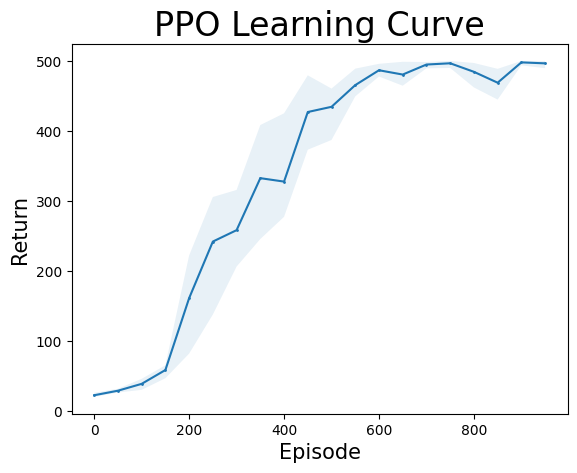

In [22]:
# Define parameter values
env_name = 'CartPole-v1' # environment name
# env_name = 'Pendulum-v1' # environment name
# env_name = "MountainCarContinuous-v0"

# env_name = 'LunarLander-v2' # environment name
# env_name = 'MountainCar-v0' # environment name
# env_name = 'Acrobot-v1' # environment name


num_train_ite = 1000 # number of training iterations
num_seeds = 3 # fit model with 3 different seeds and plot average performance of 3 seeds
num_epochs = 10 # how many times we iterate the entire training dataset passing through the training
eval_freq = 50 # run evaluation of policy at each eval_freq trials
eval_epi_index = num_train_ite//eval_freq # use to create x label for plot
returns = np.zeros((num_seeds, eval_epi_index))
gamma = 0.999 # discount factor
lamda = 0.95 # GAE hyperparameter
clip_val = 0.2 # hyperparameter epsilon in clip objective
entropy_coef = 0.005 # hyperparameter entropy coefficient 
vf_coef = 0 # hyperparameter value function coefficient
policy_lr = 1e-4 # policy network's learning rate 
baseline_lr = 5e-4 # value network's learning rate

# Create the environment.
env = gym.make(env_name)

#detect if the environment is discrete or continuous
if isinstance(env.action_space, gym.spaces.Discrete):
    nA = env.action_space.n
else:
    nA = env.action_space.shape[0]

# detect if the environment state is discrete or continuous
if isinstance(env.observation_space, gym.spaces.Discrete):
    nS = env.observation_space.n
else:
    nS = env.observation_space.shape[0]

final_policy_nets = []
for i in tqdm.tqdm(range(num_seeds)):
    reward_means = []
    # Set random seed
    seed = np.random.randint(0, 1000)
    torch.manual_seed(seed)
    # Define policy and value networks
    if isinstance(env.action_space, gym.spaces.Discrete):
        policy_net = NeuralNet(nS, nA, torch.nn.Softmax()) # Normally this one works with CartPole-v0
    else:
        #policy_net = NeuralNet(nS, nA, torch.nn.Identity())
        policy_net = ContinuousActor(nS, nA)
    policy_net_optimizer = optim.Adam(policy_net.parameters(), lr=policy_lr)
    value_net = NeuralNet(nS, 1, torch.nn.ReLU())
    value_net_optimizer = optim.Adam(value_net.parameters(), lr=baseline_lr)
    
    for m in range(num_train_ite):
        # Train networks with PPO
        policy_net, value_net = train_PPO(env, policy_net, policy_net_optimizer, 
                                          value_net, value_net_optimizer, num_epochs, 
                                          clip_val=clip_val, gamma=gamma,
                                          entropy_coef=entropy_coef, lamda=lamda,
                                          vf_coef=vf_coef)
        if m % eval_freq == 0:
            print("Episode: {}".format(m))
            G = np.zeros(20)
            for k in range(20):
                g = evaluate_policy(env, policy_net)
                G[k] = g

            reward_mean = G.mean()
            reward_sd = G.std()
            print("The avg. test reward for episode {0} is {1} with std of {2}.".format(m, reward_mean, reward_sd))
            reward_means.append(reward_mean)
    returns[i] = np.array(reward_means)
    final_policy_nets.append(policy_net)

# save the policy network
torch.save(policy_net.state_dict(), f"PPO_policy_net_{env_name}.pt")


# Plot the performance over iterations
x = np.arange(eval_epi_index)*eval_freq
avg_returns = np.mean(returns, axis=0)
max_returns = np.max(returns, axis=0)
min_returns = np.min(returns, axis=0)

plt.fill_between(x, min_returns, max_returns, alpha=0.1)
plt.plot(x, avg_returns, '-o', markersize=1)

plt.xlabel('Episode', fontsize = 15)
plt.ylabel('Return', fontsize = 15)

plt.title("PPO Learning Curve", fontsize = 24)

In [8]:
import time
#create an environment to test and visualize the policy
env_name = 'CartPole-v1' # environment name
# env_name = 'Pendulum-v1' # environment name
# env_name = 'MountainCar-v0' # environment name
# env_name = 'Acrobot-v1' # environment name
# env_name = "MountainCarContinuous-v0"
env = gym.make(env_name, render_mode='human')

if isinstance(env.action_space, gym.spaces.Discrete):
    nS = env.observation_space.shape[0]
    nA = env.action_space.n
    policy_net = NeuralNet(nS, nA, torch.nn.Softmax())
else:
    nS = env.observation_space.shape[0]
    nA = env.action_space.shape[0]
    policy_net = ContinuousActor(nS, nA)

# load the policy network
policy_net.load_state_dict(torch.load(f"PPO_policy_net_{env_name}.pt"))
# policy_net.eval()

episodes = 5
state, _ = env.reset()
if isinstance(env.action_space, gym.spaces.Discrete):
    state = torch.from_numpy(state).float().unsqueeze(0)
else:
    state = env.reset()[0]
rewards = []
avg_rewards = []
for i in range(episodes):
    rewards = []
    while True:
        if isinstance(env.action_space, gym.spaces.Discrete):
            probs = policy_net.forward(Variable(state)) # get each action choice probability with the current policy network
            action = np.random.choice(env.action_space.n, p=np.squeeze(probs.detach().numpy())) # probablistic
        else:
            action, _ = policy_net.forward(torch.tensor(state, dtype=torch.float32))
        if isinstance(env.action_space, gym.spaces.Discrete):
            pass
        else:
            # clip action to the action space
            action = torch.clamp(action, min=-2, max=2)
            # take a selected action
            action = action.detach().numpy()
        
        
        state, reward, done, truncated, _ = env.step(action)
        if done or truncated:
            break
        state = torch.from_numpy(state.flatten()).float()
        rewards.append(reward)
    avg_rewards.append(np.sum(rewards))
    print(f"Episode {i}: {np.sum(rewards)}")
    env.reset()
print(f"Average reward: {np.mean(avg_rewards)} over {episodes} episodes")
env.close()
    

c:\Users\lisas\miniconda3\envs\Reinforce\Lib\site-packages\torch\nn\modules\module.py:1532: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)


Episode 0: 499.0


TypeError: Variable data has to be a tensor, but got numpy.ndarray

: 

In [8]:
import time
#create an environment to test and visualize the policy
env_name = 'CartPole-v1' # environment name
# env_name = 'Pendulum-v1' # environment name
# env_name = 'MountainCar-v0' # environment name
# env_name = 'Acrobot-v1' # environment name
# env_name = "MountainCarContinuous-v0"
env = gym.make(env_name, render_mode='human')

if isinstance(env.action_space, gym.spaces.Discrete):
    nS = env.observation_space.shape[0]
    nA = env.action_space.n
    policy_net = NeuralNet(nS, nA, torch.nn.Softmax())
else:
    nS = env.observation_space.shape[0]
    nA = env.action_space.shape[0]
    policy_net = ContinuousActor(nS, nA)

# load the policy network
policy_net.load_state_dict(torch.load(f"PPO_policy_net_{env_name}.pt"))
# policy_net.eval()

episodes = 5
state, _ = env.reset()
if isinstance(env.action_space, gym.spaces.Discrete):
    state = torch.from_numpy(state).float().unsqueeze(0)
else:
    state = env.reset()[0]
rewards = []
for i in range(episodes):
    rewards.append(evaluate_policy(env, policy_net))
    print(f"Episode {i}: {rewards[-1]}")
    env.reset()
print(f"Average reward: {np.mean(rewards)} over {episodes} episodes")
env.close()
    

c:\Users\lisas\miniconda3\envs\Reinforce\Lib\site-packages\torch\nn\modules\module.py:1532: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)


Episode 0: 500.0
Episode 1: 500.0
Episode 2: 500.0
Episode 3: 500.0
Episode 4: 500.0
Average reward: 500.0 over 5 episodes
